In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
#import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

print(sklearn.__version__)

0.20.3


In [60]:
from pandas import ExcelWriter
from pandas import ExcelFile
 
df = pd.read_excel('C:/Users/Aggi/Desktop/Quantiphi/Training sheet.xlsx', sheet_name='Train')

In [61]:
df.shape
#df.describe

(1196, 15)

In [62]:
#Pre-processing
df.loc[df['movie_board_rating_display_name'] == 'Not Rated', 'board_rating_reason'] = 'inter'
mine = df['board_rating_reason']

In [63]:
#Capturing N-grams and removing redundencies
prepors = mine.str.replace('sci-fi action violence','scifi_action_violence')
prepors = prepors.str.replace('sci-fi action and violence','scifi_action_violence')
prepors = prepors.str.replace('sci-fi action','scifi_action')
prepors = prepors.str.replace('sci-fi violence','scifi_violence')
prepors = prepors.str.replace('non-stop','non-stop')
prepors = prepors.str.replace('sexaul','sexual')
prepors = prepors.str.replace('PG-13','')
prepors = prepors.str.replace('PG','')
prepors = prepors.str.replace('13','')
prepors = prepors.str.replace('arts','')
prepors = prepors.str.replace('martial','martial_arts')
prepors = prepors.str.replace('-','_')
prepors = prepors.str.replace('kids','children')
prepors = prepors.str.replace('child','children')
prepors = prepors.str.replace('teen drinking','Underage_drinking')
prepors = prepors.str.replace('teen','teens')
prepors = prepors.str.replace('preteens','teens')
prepors = prepors.str.replace('nudtity','nudity')
prepors = prepors.str.replace('violents','violent')
prepors = prepors.str.replace('sexual attack','molest')

In [65]:
#Creating word counts based on the review rating reasons

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer


my_stop_words = text.ENGLISH_STOP_WORDS.union(["and","for","involving", "situations", "caterpillar", "brief", "mild", "crude", "content", "partial", "elements", "comments", "strong", "use", "graphic", "scene", "situation", "audiences", "inter", "moments", "edited", "version", "originally", "rated", "frequent", "sustained", "pending", "momentary", "re_rated", "image", "edits", "coarse", "extended", "edition", "realistic", "dequences", "moment", "materials", "descriptions","images", "including", "references", "suggestive", "thematic", "material","general","intense", "mature", "pervasive"])

vectorizer =  CountVectorizer(ngram_range=(1,1), stop_words=my_stop_words)

X = vectorizer.fit_transform(prepors)

#idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.))

# printing the tfidf vectors
#print(X)

print(X.shape)


# printing the vocabulary
print(vectorizer.vocabulary_)

(1196, 154)
{'epic': 50, 'battle': 14, 'sequences': 122, 'warfare': 151, 'sensuality': 120, 'language': 80, 'smoking': 131, 'action': 3, 'violence': 148, 'frightening': 60, 'prolonged': 99, 'scifi_action_violence': 117, 'mayhem': 85, 'destruction': 39, 'sexuality': 126, 'innuendo': 75, 'adventure': 5, 'fantasy': 55, 'scary': 113, 'menace': 86, 'rude': 111, 'humor': 71, 'peril': 97, 'sexual': 125, 'drug': 45, 'swashbuckling': 139, 'disaster': 41, 'disturbing': 42, 'nudity': 95, 'martial_arts': 83, 'violent': 149, 'teenss': 141, 'sex_related': 124, 'adventures': 6, 'irreverent': 77, 'startling': 133, 'color': 29, 'scifi_violence': 118, 'emotional': 49, 'scifi_action': 116, 'drunkenness': 48, 'bullying': 22, 'bloody': 17, 'war': 150, 'male': 82, 'rear': 105, 'sci_fi': 115, 'western': 152, 'choreography': 27, 'horror': 70, 'comic': 31, 'brutal': 20, 'rape': 103, 'torture': 144, 'alcohol': 7, 'reference': 107, 'gangster': 61, 'appeal': 10, 'teens': 140, 'underage_drinking': 146, 'accident':

In [66]:
#Creating a DF using count vectorizer output
features_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [67]:
#Deleteing the review reasons detailed statement column
df.pop('board_rating_reason')
features_df.shape

(1196, 154)

In [68]:
#Combining orginal data and the word counts dataframe
train_in = pd.concat([df,features_df],axis=1)
#Removing unnecessary columns
train_in.drop(['total','id','name','display_name','production_year'], axis=1, inplace=True)
train_in.shape

(1196, 163)

In [69]:
#Sperating the predictor variable
trainy = train_in['Category']
train_in.drop(['Category'], axis=1, inplace=True)
train_in.shape

(1196, 162)

In [71]:
#Creating dummy variables for categorical variables
train_in = train_in.replace(' ', '_', regex=True)
creative_type = pd.get_dummies(train_in['creative_type'])
source = pd.get_dummies(train_in['source'])
production_method = pd.get_dummies(train_in['production_method'])
genre = pd.get_dummies(train_in['genre'])
language = pd.get_dummies(train_in['language'])
movie_board_rating_display_name = pd.get_dummies(train_in['movie_board_rating_display_name'])
movie_release_pattern_display_name = pd.get_dummies(train_in['movie_release_pattern_display_name'])

In [72]:
#Concatinating all dummy variables in to one DF
train_f = pd.concat([train_in,creative_type,source,production_method,genre,language,movie_board_rating_display_name,movie_release_pattern_display_name],axis=1)

In [73]:
#Dropping the orginal variables used for creating dummy variables
train_f.drop(['creative_type','source','production_method','genre','language','movie_board_rating_display_name','movie_release_pattern_display_name'], axis=1, inplace=True)

In [75]:
#Unbalnced dataset - Category buckets
trainy.value_counts()

2    247
3    245
4    206
1    168
5    132
6     80
7     61
8     38
9     19
Name: Category, dtype: int64

In [79]:
#Using Oversampling technique to balance the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
x_res, y_res = sm.fit_sample(train_f, trainy)
yhat = pd.Series(y_res)
yhat.value_counts()

9    247
7    247
5    247
3    247
1    247
8    247
6    247
4    247
2    247
dtype: int64

In [80]:
x_res.shape

(2223, 227)

Model-Based Feature Selection
uses a supervised model to determine the importance of each feature
keeps the most important features
needs a measure for the importance of features (DT and RF have the 'feature_importances' attribute)

In [85]:
#Feature selection based on variable importance from Random Forest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_split = 15), threshold='mean')

In [86]:
select.fit(x_res, y_res)
X_train_s = select.transform(x_res)
print('The shape of X_train is: ', x_res.shape)
print('The shape of X_train_s is ', X_train_s.shape)

The shape of X_train is:  (2223, 227)
The shape of X_train_s is  (2223, 51)


In [87]:
feature_idx = select.get_support()
feature_name = train_f.columns[feature_idx]
feature_name

Index(['movie_sequel', 'action', 'bloody', 'disturbing', 'drug', 'frightening',
       'humor', 'nudity', 'rude', 'scifi_action_violence', 'sensuality',
       'sequences', 'sexual', 'sexuality', 'smoking', 'violence', 'violent',
       'Contemporary_Fiction', 'Dramatization', 'Factual', 'Fantasy',
       'Historical_Fiction', 'Kids_Fiction', 'Science_Fiction', 'Super_Hero',
       'Based_on_Comic/Graphic_Novel', 'Based_on_Factual_Book/Article',
       'Based_on_Fiction_Book/Short_Story', 'Based_on_Real_Life_Events',
       'Based_on_TV', 'Original_Screenplay', 'Remake', 'Animation/Live_Action',
       'Digital_Animation', 'Live_Action', 'Action', 'Adventure', 'Comedy',
       'Documentary', 'Drama', 'Horror', 'Romantic_Comedy',
       'Thriller/Suspense', 'language_English', 'G', 'Not_Rated', 'PG',
       'PG-13', 'R', 'Limited', 'Wide'],
      dtype='object')

Text(0.5, 0, 'Index of Features')

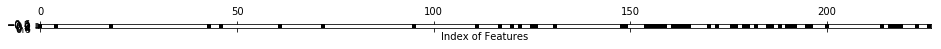

In [88]:
#Checking which variables got selected 
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Index of Features')

In [89]:
#Splitting data in train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_s, y_res, stratify=y_res, random_state=42, test_size = 0.25)

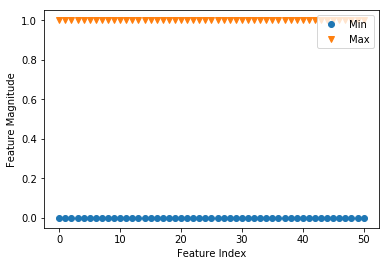

In [111]:
#Checking the scale of all variables
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(X_train.min(axis=0), 'o', label='Min')
plt.plot(X_train.max(axis=0), 'v', label='Max')
plt.xlabel('Feature Index')
plt.ylabel('Feature Magnitude')
#plt.yscale('log')
plt.legend(loc='upper right')

In [ ]:
# Using Randomized Search to narrow down on best parameters

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [70]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 78,
 'bootstrap': False}

In [94]:
#using the parameters from Random search as a starting point narrowing down the best parameters using gridsearch

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': ['True','False'],
    'max_depth': [70,100,120],
    'min_samples_leaf': [1,2,5],
    'min_samples_split': [3,5,10],
    'n_estimators': [700,800,900]
}
# Create a based model
rf = RandomForestRegressor(max_features = 'sqrt')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [95]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  8.2min finished


In [96]:
print(best_grid)

RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [100]:
# Based on the best parameters fiting the final Random Forest 

forest = RandomForestClassifier(n_estimators=800, random_state=42, min_samples_split = 5,bootstrap = True, max_depth = 100,max_features='sqrt',min_samples_leaf = 1)
forest.fit(X_train, y_train)

print('Accuracy on the training subset: {:.3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on the test subset: {:.3f}'.format(forest.score(X_test, y_test)))



Accuracy on the training subset: 0.888
Accuracy on the test subset: 0.568


Index(['movie_sequel', 'action', 'bloody', 'disturbing', 'drug', 'frightening',
       'humor', 'nudity', 'rude', 'scifi_action_violence', 'sensuality',
       'sequences', 'sexual', 'sexuality', 'smoking', 'violence', 'violent',
       'Contemporary_Fiction', 'Dramatization', 'Factual', 'Fantasy',
       'Historical_Fiction', 'Kids_Fiction', 'Science_Fiction', 'Super_Hero',
       'Based_on_Comic/Graphic_Novel', 'Based_on_Factual_Book/Article',
       'Based_on_Fiction_Book/Short_Story', 'Based_on_Real_Life_Events',
       'Based_on_TV', 'Original_Screenplay', 'Remake', 'Animation/Live_Action',
       'Digital_Animation', 'Live_Action', 'Action', 'Adventure', 'Comedy',
       'Documentary', 'Drama', 'Horror', 'Romantic_Comedy',
       'Thriller/Suspense', 'language_English', 'G', 'Not_Rated', 'PG',
       'PG-13', 'R', 'Limited', 'Wide'],
      dtype='object')


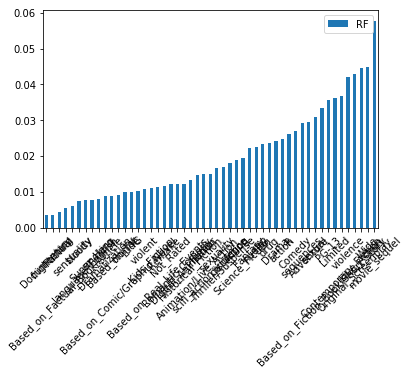

In [101]:
#Plotting feature importance 

feature_idx = select.get_support()
feature_name = train_f.columns[feature_idx]

#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(feature_name, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RF'})
importances.sort_values(by='RF').plot(kind='bar', rot=45)
print(feature_name)

In [103]:
#Naive Bayes Classifier

# importing necessary libraries 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

  
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
accuracy_train = gnb.score(X_train, y_train) 
print(accuracy_train)

# accuracy on X_test 
accuracy_test = gnb.score(X_test, y_test) 
print(accuracy_test)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 

#0.29208472686733555
#0.14046822742474915

0.28014397120575885
0.26798561151079137


In [66]:
#Applying grid search to identify best parameters for "RBF Kernal based SVM"
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.1, 10, 100, 200,1000]
    gammas = [0.05, 0.1,2,5,10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [67]:
svc_param_selection(X_train, y_train, 3)

C:\Users\Aggi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 100, 'gamma': 0.1}

In [104]:
# training a SVM classifier with best parameters from grid search
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'rbf',gamma = 0.1, decision_function_shape = 'ovo',random_state = 42, C=100)
#svm_predictions = svm_model_linear.predict(X_test) 

svm_model_linear.fit(X_train, y_train) 

accuracy_train_svm = svm_model_linear.score(X_train, y_train) 
print(accuracy_train_svm)

# accuracy on X_test 
accuracy_test_svm = svm_model_linear.score(X_test, y_test) 
print(accuracy_test_svm)

  
# creating a confusion matrix 
#cm_svm = confusion_matrix(y_test, svm_predictions) 

0.9070185962807439
0.5215827338129496


In [105]:
# Gamma = Scale option works beter than Grid search
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'rbf',gamma = 'scale', decision_function_shape = 'ovo',random_state = 42, C=5000)
#svm_predictions = svm_model_linear.predict(X_test) 

svm_model_linear.fit(X_train, y_train) 

accuracy_train_svm = svm_model_linear.score(X_train, y_train) 
print(accuracy_train_svm)

# accuracy on X_test 
accuracy_test_svm = svm_model_linear.score(X_test, y_test) 
print(accuracy_test_svm)

  
# creating a confusion matrix 
#cm_svm = confusion_matrix(y_test, svm_predictions) 

0.9070185962807439
0.5251798561151079


In [73]:
#Applying grid search to identify best parameters for polynomial kernal based SVM"
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.1, 10, 100, 200,1000]
    gammas = [0.05, 0.1,2,5,10]
    degrees = [3,4,5,6,7]
    param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees}
    grid_search = GridSearchCV(svm.SVC(kernel='poly'), param_grid, cv=nfolds)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svc_param_selection(X_train, y_train, 3)

In [ ]:
grid_search.best_params_

In [109]:
# training a linear SVM classifier 
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'poly', degree = 5, gamma = 1, decision_function_shape = 'ovo',random_state = 42, C = 5000).fit(X_train, y_train) 
#svm_predictions = svm_model_linear.predict(X_test) 

accuracy_train_svm = svm_model_linear.score(X_train, y_train) 
print(accuracy_train_svm)

# accuracy on X_test 
accuracy_test_svm = svm_model_linear.score(X_test, y_test) 
print(accuracy_test_svm)

  
# creating a confusion matrix 
#cm_svm = confusion_matrix(y_test, svm_predictions) 

0.9070185962807439
0.5305755395683454


In [106]:
# Gamma = Scale option works beter than Grid search
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'poly', degree = 6, gamma = 'scale', decision_function_shape = 'ovo',random_state = 42, C = 5000).fit(X_train, y_train) 
#svm_predictions = svm_model_linear.predict(X_test) 

accuracy_train_svm = svm_model_linear.score(X_train, y_train) 
print(accuracy_train_svm)

# accuracy on X_test 
accuracy_test_svm = svm_model_linear.score(X_test, y_test) 
print(accuracy_test_svm)

  
# creating a confusion matrix 
#cm_svm = confusion_matrix(y_test, svm_predictions) 

0.9070185962807439
0.5467625899280576


In [50]:
# training a linear SVM classifier 
from sklearn import svm
from sklearn.svm import SVC 
#svm_model_linear = SVC(kernel = 'linear', C = 100).fit(X_train, y_train) 
#svm_predictions = svm_model_linear.predict(X_test) 

from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel = 'poly', gamma = 'scale', decision_function_shape = 'ovo',random_state = 42, C = 1000)
scores = cross_val_score(clf, X_test, y_test, cv=5)
scores  

cvmod = clf.fit(X_train, y_train) 

accuracy_test_svm = cvmod.score(X_test, y_test) 
print(accuracy_test_svm)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  
#creating a confusion matrix 
#cm_svm = confusion_matrix(y_test, svm_predictions) 

0.49280575539568344
Accuracy: 0.40 (+/- 0.04)


0.778149386845039
0.23745819397993312

0.725752508361204
0.2976588628762542

0.673355629877369
0.24749163879598662

mean 
.5562987736900781
0.27759197324414714

median pruning
0.6343366778149386
0.29431438127090304

0.6465997770345596
0.2909698996655518

In [112]:
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 25).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test)

accuracy_train_dt = dtree_model.score(X_train, y_train) 
print(accuracy_train_dt)

# accuracy on X_test 
accuracy_test_dt = dtree_model.score(X_test, y_test) 
print(accuracy_test_dt)
  
# creating a confusion matrix 
cm_dt = confusion_matrix(y_test, dtree_predictions) 

0.9070185962807439
0.5053956834532374


0.8394648829431438
0.22073578595317725

0.8472686733556298
0.2408026755852843

0.9331103678929766
0.23076923076923078

In [198]:
#Creating grid search for KNN 
k_range = list(range(1, 30,2))

# Another parameter besides k that we might vary is the weights parameters
# default options --> uniform (all points in the neighborhood are weighted equally)
# another option --> distance (weights closer neighbors more heavily than further neighbors)

# we create a list
weight_options = ['uniform', 'distance']
print(k_range)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


In [199]:
# create a parameter grid: map the parameter names to the values that should be searched
# dictionary = dict(key=values, key=values)
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], 'weights': ['uniform', 'distance']}


In [113]:
# training a KNN classifier - based on best parameters from grid search
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 3,weights='distance').fit(X_train, y_train) 

accuracy_train_knn = knn.score(X_train, y_train) 
print(accuracy_train_knn)

# accuracy on X_test 
accuracy_test_knn = knn.score(X_test, y_test) 
print(accuracy_test_knn)
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 

0.8962207558488302
0.5341726618705036


In [30]:
#Trying grid search on Neural networks for identifying best parameters

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=50)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50),(150,150,150), (50),(150)],
    'activation': ['tanh', 'logistic','relu'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1,2],
    'learning_rate': ['constant','adaptive'],
}

In [31]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=4)
clf.fit(X_train,y_train)

C:\Users\Aggi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Aggi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=50, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(50, 50, 50), (150, 150, 150), 50, 150], 'activation': ['tanh', 'logistic', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0001, 0.05, 0.1, 2], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (150, 150, 150), 'learning_rate': 'constant', 'solver': 'adam'}


Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'solver': 'lbfgs'}

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (150, 150, 150), 'learning_rate': 'constant', 'solver': 'adam'}

In [115]:
#Fitting the NN model to the best parameters

#Best parameters found:
#{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (150, 150, 150), 'learning_rate': 'constant', 'solver': 'adam'}

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(activation = 'tanh',alpha = 0.05 ,solver = 'adam', hidden_layer_sizes=(150, 150, 150),learning_rate = 'constant', max_iter=500)

mlp.fit(X_train,y_train)

accuracy_train_mlp = mlp.score(X_train, y_train) 
print(accuracy_train_mlp)

# accuracy on X_test 
accuracy_test_mlp = mlp.score(X_test, y_test) 
print(accuracy_test_mlp)

0.9058188362327535
0.5269784172661871


In [ ]:
#Grid search on Logistic Regression - multinomial

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

In [120]:
from sklearn.linear_model import LogisticRegression
logreg2=LogisticRegression(C=100.0,penalty="l2",solver = 'lbfgs', multi_class = 'multinomial',max_iter = 1000)
logreg2.fit(X_train,y_train)
print("Train accuracy",logreg2.score(X_train,y_train))
print("Test accuracy",logreg2.score(X_test,y_test))

Train accuracy 0.5296940611877624
Test accuracy 0.4172661870503597


No handles with labels found to put in legend.


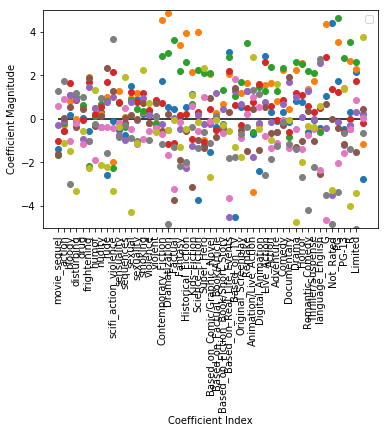

In [119]:
plt.plot(logreg2.coef_.T, 'o')
plt.xticks(range(50), feature_name, rotation=90)
plt.hlines(0,0, 50)
plt.ylim(-5,5)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend()

In [124]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [127]:
gbm0 = GradientBoostingClassifier(n_estimators=800, random_state=42, min_samples_split = 5,max_depth = 100,max_features='sqrt',min_samples_leaf = 1)
gbm0.fit(X_train, y_train)

gbm0.score(X_train,y_train)
gbm0.score(X_test,y_test)

0.5485611510791367

In [128]:
print(gbm0.score(X_train,y_train))
print(gbm0.score(X_test,y_test))

0.9070185962807439
0.5485611510791367


In [129]:
#Loading scoring sheet
from pandas import ExcelWriter
from pandas import ExcelFile
 
df_score = pd.read_excel('C:/Users/Aggi/Desktop/Quantiphi/Scoring Sheet.xlsx', sheet_name='scoring-2012-challenge (1)')

In [130]:
df_score.shape
#df.describe

(91, 14)

In [131]:
#Pre-processing
df_score.loc[df_score['movie_board_rating_display_name'] == 'Not Rated', 'board_rating_reason'] = 'inter'
mine = df_score['board_rating_reason']

In [132]:
#Capturing N-grams and removing redundencies
prepors = mine.str.replace('sci-fi action violence','scifi_action_violence')
prepors = prepors.str.replace('sci-fi action and violence','scifi_action_violence')
prepors = prepors.str.replace('sci-fi action','scifi_action')
prepors = prepors.str.replace('sci-fi violence','scifi_violence')
prepors = prepors.str.replace('non-stop','non-stop')
prepors = prepors.str.replace('sexaul','sexual')
prepors = prepors.str.replace('PG-13','')
prepors = prepors.str.replace('PG','')
prepors = prepors.str.replace('13','')
prepors = prepors.str.replace('arts','')
prepors = prepors.str.replace('martial','martial_arts')
prepors = prepors.str.replace('-','_')
prepors = prepors.str.replace('kids','children')
prepors = prepors.str.replace('child','children')
prepors = prepors.str.replace('teen drinking','Underage_drinking')
prepors = prepors.str.replace('teen','teens')
prepors = prepors.str.replace('preteens','teens')
prepors = prepors.str.replace('nudtity','nudity')
prepors = prepors.str.replace('violents','violent')
prepors = prepors.str.replace('sexual attack','molest')

In [133]:
#Creating word counts based on the review rating reasons

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer


my_stop_words = text.ENGLISH_STOP_WORDS.union(["and","for","involving", "situations", "caterpillar", "brief", "mild", "crude", "content", "partial", "elements", "comments", "strong", "use", "graphic", "scene", "situation", "audiences", "inter", "moments", "edited", "version", "originally", "rated", "frequent", "sustained", "pending", "momentary", "re_rated", "image", "edits", "coarse", "extended", "edition", "realistic", "dequences", "moment", "materials", "descriptions","images", "including", "references", "suggestive", "thematic", "material","general","intense", "mature", "pervasive"])

vectorizer =  CountVectorizer(ngram_range=(1,1), stop_words=my_stop_words)

X = vectorizer.fit_transform(prepors)

#idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.))

# printing the tfidf vectors
#print(X)

print(X.shape)


# printing the vocabulary
print(vectorizer.vocabulary_)

(91, 43)
{'sequences': 32, 'scifi_violence': 29, 'action': 1, 'drug': 12, 'reference': 25, 'violence': 40, 'sensuality': 30, 'language': 19, 'violent': 41, 'sexuality': 34, 'smoking': 35, 'disturbing': 9, 'nudity': 21, 'fantasy': 14, 'frightening': 15, 'scary': 28, 'rude': 27, 'humor': 17, 'peril': 23, 'sexual': 33, 'adventure': 2, 'mildly': 20, 'alcohol': 3, 'abuse': 0, 'sequence': 31, 'bloody': 4, 'torture': 38, 'remarks': 26, 'underage_drinking': 39, 'terror': 37, 'brutal': 5, 'grisly': 16, 'domestic': 10, 'children': 6, 'imperilment': 18, 'dramatic': 11, 'partying': 22, 'perilous': 24, 'war': 42, 'depiction': 8, 'extreme': 13, 'dangerous': 7, 'stunts': 36}


In [134]:
#Creating a DF using count vectorizer output
features_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [136]:
#Deleteing the review reasons detailed statement column
df_score.pop('board_rating_reason')
features_df.shape

(91, 43)

In [138]:
#Combining orginal data and the word counts dataframe
Score_in = pd.concat([df_score,features_df],axis=1)
#Removing unnecessary columns
Score_in.drop(['id','name','display_name','production_year'], axis=1, inplace=True)
Score_in.shape

(91, 52)

In [139]:
#Creating dummy variables for categorical variables
Score_in = Score_in.replace(' ', '_', regex=True)
creative_type = pd.get_dummies(Score_in['creative_type'])
source = pd.get_dummies(Score_in['source'])
production_method = pd.get_dummies(Score_in['production_method'])
genre = pd.get_dummies(Score_in['genre'])
language = pd.get_dummies(Score_in['language'])
movie_board_rating_display_name = pd.get_dummies(Score_in['movie_board_rating_display_name'])
movie_release_pattern_display_name = pd.get_dummies(Score_in['movie_release_pattern_display_name'])

In [140]:
#Concatinating all dummy variables in to one DF
Score_f = pd.concat([Score_in,creative_type,source,production_method,genre,language,movie_board_rating_display_name,movie_release_pattern_display_name],axis=1)

In [141]:
#Dropping the orginal variables used for creating dummy variables
Score_f.drop(['creative_type','source','production_method','genre','language','movie_board_rating_display_name','movie_release_pattern_display_name'], axis=1, inplace=True)

In [144]:
feature_idx = select.get_support()
feature_name = train_f.columns[feature_idx]
feature_name

Index(['movie_sequel', 'action', 'bloody', 'disturbing', 'drug', 'frightening',
       'humor', 'nudity', 'rude', 'scifi_action_violence', 'sensuality',
       'sequences', 'sexual', 'sexuality', 'smoking', 'violence', 'violent',
       'Contemporary_Fiction', 'Dramatization', 'Factual', 'Fantasy',
       'Historical_Fiction', 'Kids_Fiction', 'Science_Fiction', 'Super_Hero',
       'Based_on_Comic/Graphic_Novel', 'Based_on_Factual_Book/Article',
       'Based_on_Fiction_Book/Short_Story', 'Based_on_Real_Life_Events',
       'Based_on_TV', 'Original_Screenplay', 'Remake', 'Animation/Live_Action',
       'Digital_Animation', 'Live_Action', 'Action', 'Adventure', 'Comedy',
       'Documentary', 'Drama', 'Horror', 'Romantic_Comedy',
       'Thriller/Suspense', 'language_English', 'G', 'Not_Rated', 'PG',
       'PG-13', 'R', 'Limited', 'Wide'],
      dtype='object')

In [159]:
left = pd.DataFrame(X_train,columns=feature_name)

In [174]:
left1 = left.head(0)

In [185]:
score_set = pd.concat([left1,Score_f],sort=False)
score_set1 = score_set[feature_name]
score_set1

,movie_sequel,action,bloody,disturbing,drug,frightening,humor,nudity,rude,scifi_action_violence,...,Romantic_Comedy,Thriller/Suspense,language_English,G,Not_Rated,PG,PG-13,R,Limited,Wide
0,0,1,0,0,1,0,0,0,0,NaN,...,0,0,1,0,0,0,1,0,0,1
1,1,1,0,0,0,0,0,0,0,NaN,...,0,0,1,0,0,0,1,0,0,1
2,1,0,0,0,0,0,0,0,0,NaN,...,0,0,1,0,0,0,1,0,0,1
3,1,0,0,1,0,0,0,1,0,NaN,...,0,0,1,0,0,0,1,0,0,1
4,1,1,0,0,0,1,0,0,0,NaN,...,0,0,1,0,0,0,1,0,0,1
5,1,1,0,0,0,0,0,0,0,NaN,...,0,0,1,0,0,0,1,0,0,1
6,0,1,0,0,0,0,1,0,1,NaN,...,0,0,1,0,0,1,0,0,0,1
7,1,1,0,0,0,0,1,0,1,NaN,...,0,0,1,0,0,1,0,0,0,1
8,0,1,0,0,0,0,1,0,1,NaN,...,0,0,1,0,0,1,0,0,0,1
9,1,1,0,0,0,0,1,0,1,NaN,...,0,0,1,0,0,1,0,0,0,1


In [188]:
#score_set1.replace({'NaN':0})

s1 = score_set1.replace(np.nan, 0)
s1.astype(int)

,movie_sequel,action,bloody,disturbing,drug,frightening,humor,nudity,rude,scifi_action_violence,...,Romantic_Comedy,Thriller/Suspense,language_English,G,Not_Rated,PG,PG-13,R,Limited,Wide
0,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
5,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
6,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1
7,1,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1
8,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1
9,1,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1


In [190]:
y_pred = forest.predict(s1)
output = pd.DataFrame(y_pred,columns=['cat'])

In [191]:
output.to_excel("output.xlsx",
            sheet_name='output')